# Shape Interpolation
(Open 'warping_anim.gif' to see warping animation)

In [1]:
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import numpy as np
import os
import glob
from PIL import Image

In [7]:

x_vector = np.array([]) #33 files and 58 points per file (1914 total entries)
y_vector = np.array([]) #33 files and 58 points per file

i = 0
for filename in os.listdir('/home/pascal/computer_graphics/shape_interpolation_HW2/imm_face_db'):
    if filename.endswith("1m.asf") :  #all male faces (straight faces)
         x_s, y_s = get_landmarks(filename)
         x_vector = np.append(x_vector, [[x_s]])
         y_vector = np.append(y_vector, [[y_s]])
         i = i+1
         continue
    else:
        continue

print("File num: %d" % i)

print('x pixel of 1st file: %f ' % x_vector[0]) # Manually compute this for check (27-1m.asf)
print('x_pixel of last file: %f' % x_vector[1913]) # (18-1m.asf)
print('Length of y vector: %d ' % y_vector.shape)


File num: 33
x pixel of 1st file: 231.992320 
x_pixel of last file: 321.790317
Length of y vector: 1914 


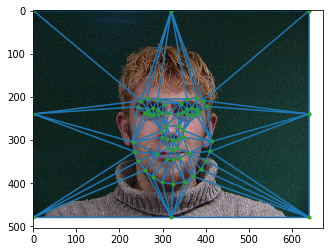


 Original S1


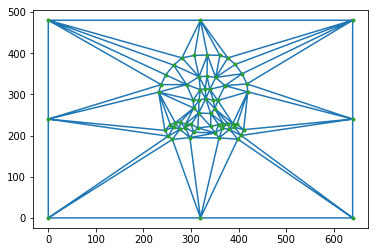


 S1 with edges transfered from average shape


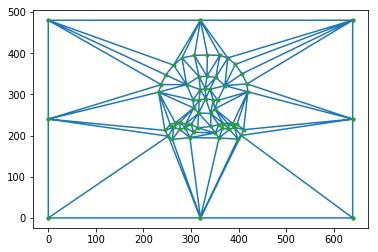


 Average shape


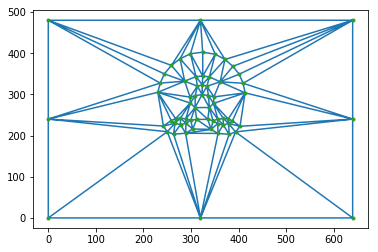

In [54]:

N_faces = 33
x_matrix = np.reshape(x_vector, (33, 58)) # now each image is a row in this matrix
y_matrix = np.reshape(y_vector, (33, 58))

s1 = np.zeros((58,2))
s2 = np.zeros((58, 2))
s1[:,0] = x_matrix[0]
s1[:,1] = y_matrix[0]

s2[:,0] = x_matrix[1]
s2[:,1] = y_matrix[1]

gen_warping_seq(s1, s2)

frames = []
imgs = glob.glob("*.jpg")
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)
 
# Save into a GIF file that loops forever
frames[0].save('warping_anim.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=300, loop=0)

avg_x_mtrx = np.array(np.sum(x_matrix, axis=0)/N_faces)
avg_y_mtrx = np.array(np.sum(y_matrix, axis=0)/N_faces)

avg_male = np.zeros((58,2))
avg_male[:,0] = avg_x_mtrx
avg_male[:,1] = avg_y_mtrx

avg_male = add_corners_and_edges(avg_male)
avg_male_tri = Delaunay(avg_male)
img = '/home/pascal/computer_graphics/shape_interpolation_HW2/imm_face_db/01-1m.jpg'
plot_delaunay(avg_male, avg_male_tri, img)
# compute_delaunay_tri(avg_male)
 
s1 = add_corners_and_edges(s1)
s1_transf, s1_transf_tri = transfer_tri(s1, avg_male_tri) #Transfer edges for average shape to shape s1

print("\n Original S1")
plot_shape_tri(s1, s1_tri)


print("\n S1 with edges transfered from average shape")
plot_shape_tri(s1_transf, s1_transf_tri)


print("\n Average shape")
plot_shape_tri(avg_male, avg_male_tri)

# Triangulation vertices are all different, not sure why. I was expecting 
# Triangualtion vertices of s1 and s1_transf to be the same
# print("\n Comparing triangulation vertices after transfer...")
# print("S1")
# print(s1[s1_tri.simplices[0]])
# print("S1 transf")
# print(s1_transf[s1_transf_tri.simplices[0]])
# print("Avg male")
# print(avg_male[avg_male_tri.simplices[0]])






In [52]:
def plot_shape_tri(s, s_tri):
    plt.triplot(s[:,0], s[:,1], s_tri.simplices.copy())
    plt.plot(s[:,0], s[:,1],'.')
    plt.show()


In [44]:
def transfer_tri(pts1, pts2_tri):
    pts1_t = pts1 #target for transfer, we firt copy all the points in the target (_t is for transfer)

    pts1_tri = Delaunay(pts1)
    pts1_t_tri = Delaunay(pts1_t)

    pts1_t_tri.simplices = pts2_tri.simplices #copy edges from the second triangulation 

    return pts1_t, pts1_t_tri


In [2]:
def gen_warping_seq(s1, s2):
    def my_range(sta, end, stp):
        while sta <= end:
            yield sta
            sta += stp

    for a in my_range(0, 1, 0.1):
        sj = (1-a)*s1 + a*s2
        delaunay_tri = Delaunay(sj)  
        plt.triplot(sj[:,0], sj[:,1], delaunay_tri.simplices.copy())
        plt.plot(sj[:,0], sj[:,1],'.')

        plt.gca().invert_yaxis() #Flip the print

        plt.savefig('warping_'+str(a)+'.jpg')
        plt.clf() #clear plt


In [3]:
def plot_delaunay(points, tri, img) :
    img = plt.imread(img)
    imgplot = plt.imshow(img)
    plt.triplot(points[:,0], points[:,1], tri.simplices.copy())
    plt.plot(points[:,0], points[:,1],'.')
    plt.show()

In [4]:
def add_corners_and_edges(pts):
    points = np.append(pts, [[0,0], [0,480], [640,0],[640,480],[0,480/2], [640, 480/2], [640/2, 0],[640/2, 480]], axis=0)
    return points

In [5]:
def get_landmarks(filename):
    TOTAL_POINTS = 58
    x_s = np.zeros((0,1))
    y_s = np.zeros((0,1))
    landmark_file = open("./imm_face_db/"+ filename, "r")

    for i in range(80):
        line = landmark_file.readline()
        if (i >= 16) & (i <= 16 + (TOTAL_POINTS-1)) : #landmark indices start at on line 16
            line_16 = line
            splitted_line = line_16.split("\t", 4)
            x = splitted_line[2]
            y = splitted_line[3]
            x_pixel = float(x)*640 #Multiply by image width (Why isn't this returning an integer?)
            y_pixel = float(y)*480 #Multiply by image heighh
            x_s = np.append(x_s, [[x_pixel]])
            y_s = np.append(y_s, [[y_pixel]])
  
    landmark_file.close()
    return x_s, y_s